In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ pars

In [2]:
#Read the dataset
pulsar_data <- read_csv("data/HTRU_2.csv")

Rows: 17897 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): 140.5625, 55.68378214, -0.234571412, -0.699648398, 3.199832776, 19....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#Perform initial cleaning:
colnames(pulsar_data) <- c('mean_profile', 'std_profile', 
                            'kurtosis_profile', 'skewness_profile', 
                            'mean_dmsnr', 'std_dmsnr', 'kurtosis_dmsnr', 
                            'skewness_dmsnr', "is_pulsar")

pulsar_data <- pulsar_data %>% mutate(is_pulsar = as_factor(is_pulsar))

pulsar_data

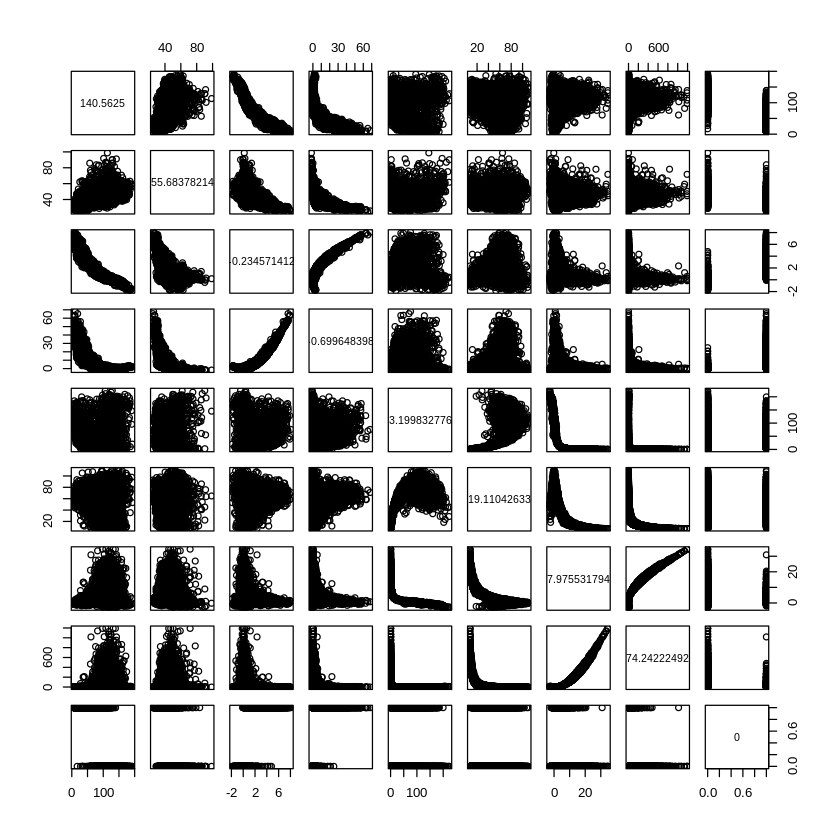

In [5]:
#data exploration

pairs(pulsar_data)|>
par(cex=2)

In [7]:
#Scatterplot of all data using selected attributes

data_plot <- ggplot(pulsar_data, aes(x = mean_profile, y = skewness_profile, color = is_pulsar)) +
  geom_point(alpha = 0.5) +
  labs(x = "Mean of the Integrated Profile",
       y = "Skewness of the Integrated Profile",
       color = "Pulsar Status",
       title = "Complete Data: Mean and Skewness of the Integrated Profile") +
  theme_minimal()

In [ ]:
#Split the dataset into training and testing sets:
set.seed(1)
data_split <- initial_split(pulsar_data, prop = 0.75, strata = is_pulsar)
train_data <- training(data_split)
test_data <- testing(data_split)

# Visualize the distribution of the mean_profile and skewness_profile for pulsars and non-pulsars in the training data
train_data_plot <- ggplot(train_data, aes(x = mean_profile, y = skewness_profile, color = is_pulsar)) +
  geom_point(alpha = 0.5) +
  labs(x = "Mean of the Integrated Profile",
       y = "Skewness of the Integrated Profile",
       color = "Pulsar Status",
       title = "Training Data: Mean and Skewness of the Integrated Profile") +
  theme_minimal()

train_data_plot

In [ ]:
#Create a KNN classification model using tidymodels:

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_workflow <- workflow() %>%
  add_model(knn_spec) %>%
  add_recipe(recipe(is_pulsar ~ mean_profile + skewness_profile, data = train_data))

In [ ]:
#Perform cross-validation to determine the optimal number of neighbors:
set.seed(1)
knn_vfold <- vfold_cv(train_data, v = 5, strata = is_pulsar)

knn_grid <- tibble(neighbors = seq(1, 30))

knn_tuned <- tune_grid(
  knn_workflow,
  resamples = knn_vfold,
  grid = knn_grid,
  metrics = metric_set(accuracy, recall, precision, f_meas)
)

In [ ]:
#Select the best KNN model based on the optimal number of neighbors:

best_k <- knn_tuned %>%
  select_best(metric = "f_meas")

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k$neighbors) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_final_workflow <- workflow() %>%
  add_model(knn_best_spec) %>%
  add_recipe(recipe(is_pulsar ~ mean_profile + skewness_profile, data = train_data))

knn_final_fit <- knn_final_workflow %>% fit(data = train_data)


In [ ]:
#Evaluate the model on the test set:

test_results <- knn_final_fit %>%
  predict(test_data) %>%
  bind_cols(test_data) %>%
  metrics(truth = is_pulsar, estimate = .pred_class)

test_results

In [ ]:
#Create a scatterplot to visualize the classification results:
predictions <- knn_final_fit %>% predict(test_data) %>% bind_cols(test_data)

test_data_plot <- ggplot(predictions, aes(x = mean_profile, y = skewness_profile, color = is_pulsar)) +
  geom_point(alpha = 0.5) +
  labs(x = "Mean of the Integrated Profile",
       y = "Skewness of the Integrated Profile",
       color = "True Pulsar Status",
       title = "Test Data: Mean and Skewness of the Integrated Profile (True Labels)") +
  theme_minimal()

test_data_plot

predictions_plot <- ggplot(predictions, aes(x = mean_profile, y = skewness_profile, color = .pred_class)) +
  geom_point() +
  labs(x = "Mean of the Integrated Profile",
       y = "Skewness of the Integrated Profile",
       color = "Predicted Pulsar Status",
       title = "KNN Classification Results") +
  theme_minimal()

predictions_plot